## Injecting back lost modes

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import pymaster as nmt

In [3]:
NSIDE = 512
lmax = 2*NSIDE

In [4]:
def D_ell(maps, lmax, use_pixel_weights=False):
    l_arr = np.arange(0,lmax+1)
    cl_s = hp.anafast(maps, lmax=lmax,use_pixel_weights=use_pixel_weights)
    return (cl_s[:]*l_arr*(l_arr+1)/(2*np.pi))

In [5]:
l_arr = np.arange(0,lmax+1)

In [6]:
planck_sim = 'cmbnoise_28scan/'
s4_sim_dc0 = 'cmb_s4scan_dc0/'
s4_sim_destriping = 'cmb_s4scan_destriping/'

In [7]:
mode_list = ['T','E','B']

In [8]:
aposcale = .1

Input map contains CMB and Planck noise

In [9]:
cmbnoise_input = hp.read_map(filename='cmbnoise_030_GC_nside.FITS',field = None)

In [10]:
cmb_input = hp.read_map(filename='cmb_030_GC_nside.FITS',field = None)

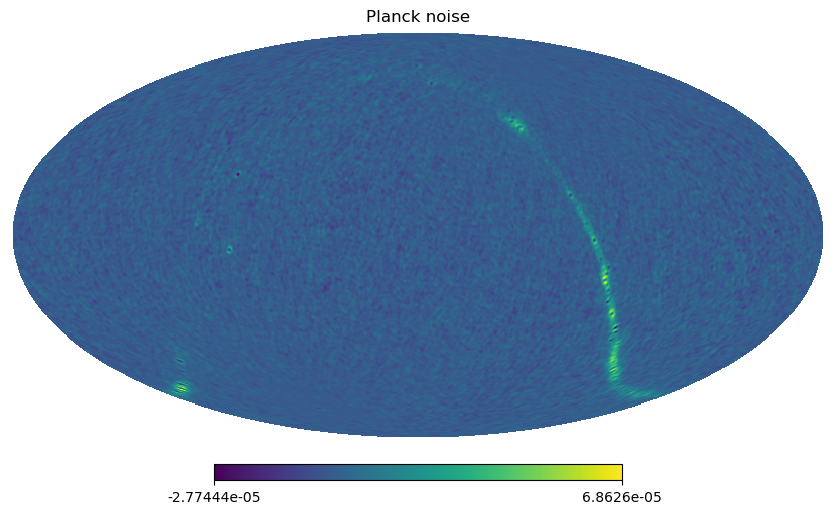

In [11]:
hp.mollview((cmbnoise_input-cmb_input)[0],title = 'Planck noise')

In [12]:
noise_GC512 = hp.read_map('noise_030_GC_nside.FITS',field=None)

Both pipelines are performed on a noisy Planck map $bs+n$

In [13]:
#cmbnoise_destriping= hp.read_map("planck_28scan/MapMaker_map.fits", dtype = float,field = None)
#cmbnoise_rcond= hp.read_map("planck_28scan/MapMaker_rcond.fits", dtype = float,field = None)
cmbnoise_dc0= hp.read_map(planck_sim+"/FilterBin_filtered_map.fits", dtype = float,field = None)
cmbnoise_rcond_dc0= hp.read_map(planck_sim+"/FilterBin_rcond.fits", dtype = float,field = None)
cmbnoise_destriping= hp.read_map(planck_sim+"/MapMaker_map.fits", dtype = float,field = None)
cmbnoise_rcond= hp.read_map(planck_sim+"/MapMaker_rcond.fits", dtype = float,field = None)

Both pipelines are performed on a sky-signal map with detector noise $bs\rightarrow $Noisy TOD

In [14]:
s4sim_destriping= hp.read_map(s4_sim_destriping+"/MapMaker_map.fits", dtype = float,field = None)
s4sim_rcond= hp.read_map(s4_sim_destriping+"/MapMaker_rcond.fits", dtype = float,field = None)
s4sim_dc0= hp.read_map(s4_sim_dc0+"/FilterBin_filtered_map.fits", dtype = float,field = None)
s4sim_rcond_dc0= hp.read_map(s4_sim_dc0+"/FilterBin_rcond.fits", dtype = float,field = None)

In [15]:
def rcond_mask_apodized(map_rcond,thrsh = 1e-3,apo = aposcale):
    mask_map = np.zeros(map_rcond.shape)
    mask_map[map_rcond>thrsh]=1
    mask_map_sm = nmt.mask_apodization(mask_map, apo, apotype="Smooth")
    return(mask_map_sm)

In [16]:
def masked_map(map_in,mask):
    temp = np.zeros(map_in.shape)
    temp[:,:] = map_in[:,:]
    temp[:,mask==0] = hp.UNSEEN
    return(temp)

In [17]:
mask_sm = rcond_mask_apodized(cmbnoise_rcond)

In [18]:
np.save(file='Apodized_mask', arr=mask_sm)

In [19]:
masked_cmbnoise_in = masked_map(map_in=cmbnoise_input,mask=mask_sm)
masked_cmbnoisedc0 = masked_map(map_in=cmbnoise_dc0,mask=mask_sm)
masked_cmbnoisedestriping = masked_map(map_in=cmbnoise_destriping,mask=mask_sm)
masked_s4_dc0 = masked_map(map_in=s4sim_dc0,mask=mask_sm)
masked_s4_destriping = masked_map(map_in=s4sim_destriping,mask=mask_sm)

In [20]:
masked_cmb_in = masked_map(map_in=cmb_input,mask=mask_sm)


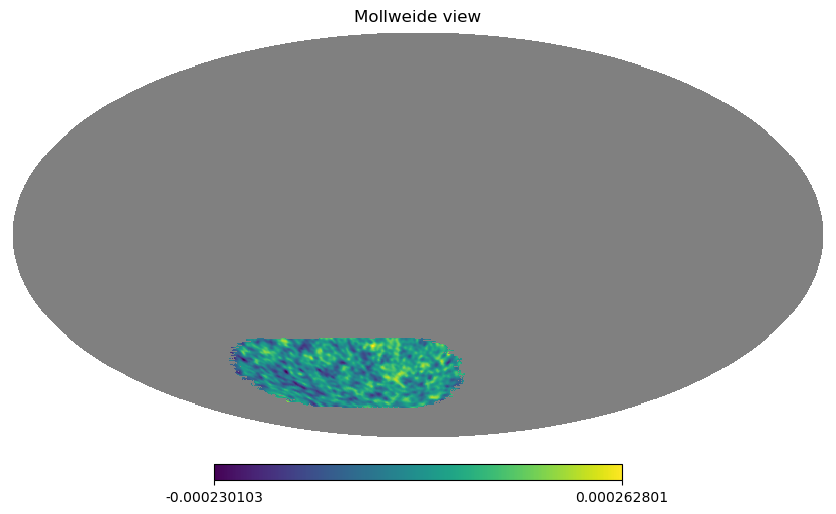

In [21]:
hp.mollview(masked_cmbnoise_in[0])

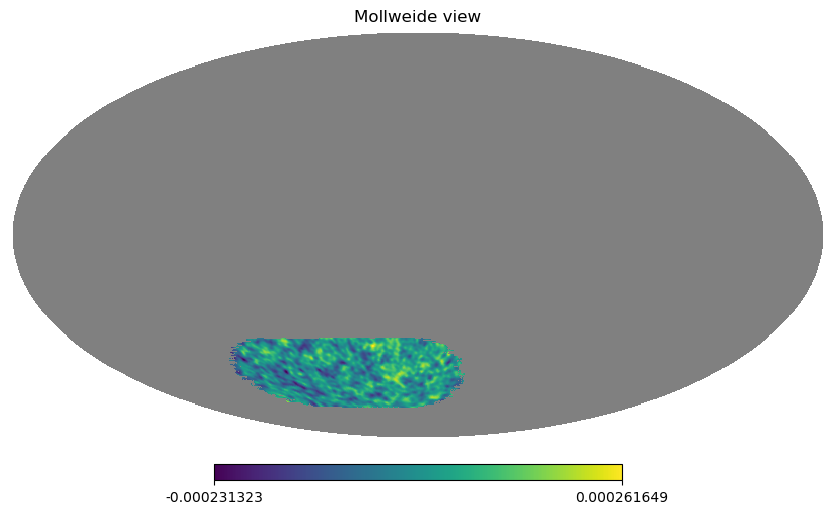

In [22]:
hp.mollview(masked_cmbnoisedestriping[0])

In [23]:
diff_desdc0 = masked_cmbnoisedestriping-masked_cmbnoisedc0
masked_diff_desdc0 = masked_map(diff_desdc0,mask_sm)

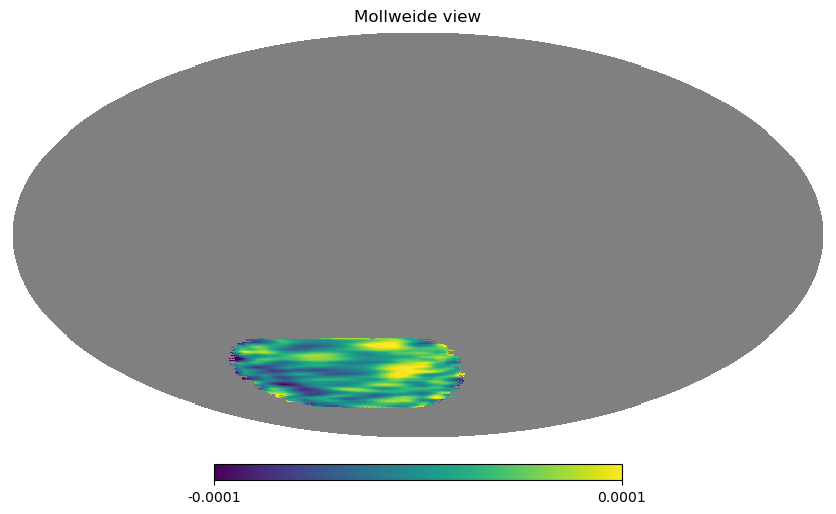

In [24]:
hp.mollview(masked_diff_desdc0[0],min = -1e-4,max = 1e-4)

1. Compute residual maps $\delta m = T(m_{in})-m_{in}$ with $m_{in} = bs+n$ for both pipelines (dc0 and destriping)

In [25]:
delta_destriping = masked_cmbnoisedestriping-masked_cmbnoise_in
delta_dc0 = masked_cmbnoisedc0-masked_cmbnoise_in

2. Add residuals to extracted maps with detector noise in the timestream, should get : $m_{cor} = bs + n^{S4}+ T(n^{Planck})$

In [26]:
masked_s4_dc0_cor = masked_s4_dc0 -delta_dc0
masked_s4_destriping_cor = masked_s4_destriping - delta_destriping

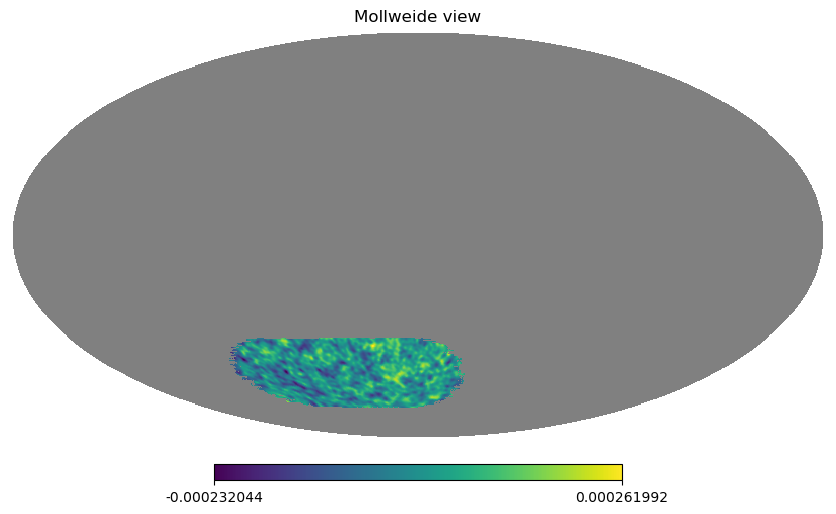

In [27]:
hp.mollview(masked_s4_dc0_cor[0])

In [28]:
diff = (masked_cmbnoisedestriping-masked_cmb_in)
diff_mask = masked_map(diff,mask_sm)

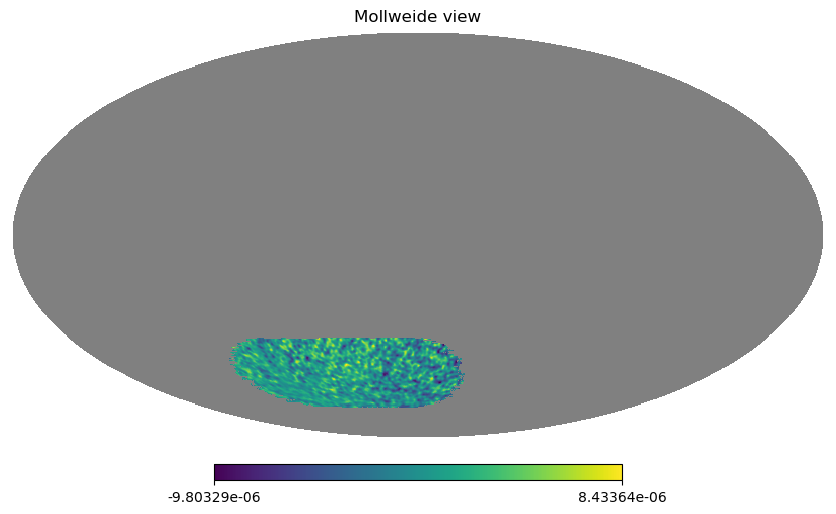

In [29]:
hp.mollview(diff_mask[1])

In [30]:
Dl_s4_destriping = D_ell(masked_s4_destriping,lmax = lmax)
Dl_s4_dc0 = D_ell(masked_s4_dc0,lmax = lmax)

In [31]:
Dl_in = D_ell(cmb_input,lmax = lmax)


In [32]:
Dl_in_noise = D_ell(cmbnoise_input,lmax = lmax)
Dl_in_noise_mask = D_ell(masked_cmbnoise_in,lmax= lmax)

In [33]:
Dl_in_mask = D_ell(masked_cmb_in,lmax= lmax)

In [34]:
Dl_s4_destriping_cor = D_ell(masked_s4_destriping_cor,lmax = lmax)
Dl_s4_dc0_cor = D_ell(masked_s4_dc0_cor,lmax = lmax)


In [35]:
hit_mask_noise = np.array(np.where(mask_sm<=0))[0]
sky_fraction= 1-(len(hit_mask_noise) / len(mask_sm))
print(f"The map covers {sky_fraction:.1%} of the sky")

The map covers 5.2% of the sky


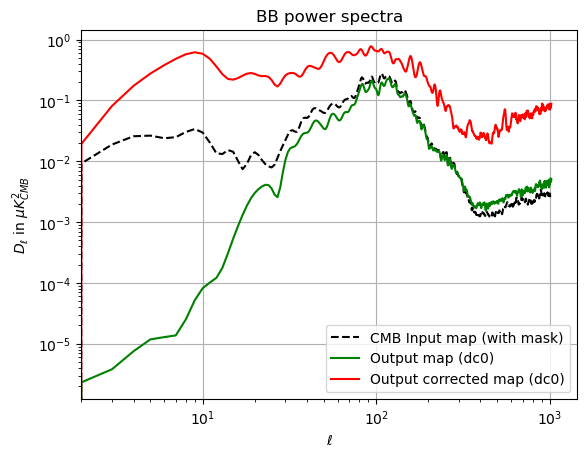

In [36]:
plt.plot(l_arr,Dl_in_mask[2]*1e12/sky_fraction, 'k--', label = r'CMB Input map (with mask)')
#plt.plot(l_arr,Dl_in[0]*1e12, 'b-', label = r'CMB Input map (without mask)')
#plt.plot(l_arr,Dl_in_noise_mask[0]*1e12/sky_fraction, 'g-', label = r'CMB+noise Input map (with mask)')
#plt.plot(l_arr,Dl_in_noise[0]*1e12, 'r-', label = r'CMB+noise Input map (without mask)')
#plt.plot(l_arr,Dl_s4_destriping[2]*1e12/sky_fraction, 'r-', label = r'Output map (destriping)')
#plt.plot(l_arr,Dl_s4_destriping[2]/Dl_in_mask[2], 'r-', label = r'Ratio')
#plt.plot(l_arr,Dl_s4_destriping_cor[2]/Dl_in_mask[2], 'b-', label = r'Ratio with mode addition from Planck')

#plt.plot(l_arr,Dl_s4_destriping_cor[2]*1e12/sky_fraction, 'b-', label = r'Output corrected map (destriping)')

plt.plot(l_arr,Dl_s4_dc0[2]*1e12/sky_fraction, 'g-', label = r'Output map (dc0)')
plt.plot(l_arr,Dl_s4_dc0_cor[2]*1e12/sky_fraction, 'r-', label = r'Output corrected map (dc0)')

#plt.plot(l_arr,Dl_diff_noise[0]*1e12/sky_fraction, 'r.', label = r'Residual map')
plt.xlabel('$\ell$')
plt.ylabel('$D_{\ell}$ in $\mu K_{CMB}^2$')
plt.legend(loc = 'best')
plt.xscale('log')
plt.yscale('log')
plt.title(2*mode_list[2]+' power spectra')
plt.xlim(left = 2)
plt.grid()
##plt.savefig(output_noise+'/cls_comparison'+2*mode_list[0],format = 'svg')
plt.show()

In [37]:
cmb_destriping = hp.read_map('cmb_28scan/MapMaker_map.fits',field=None)

In [38]:
cmb_dc0 = hp.read_map('cmb_28scan/FilterBin_filtered_map.fits',field=None)

In [39]:
mask_cmb_des = masked_map(cmb_destriping,mask_sm)

In [40]:
Dl_cmb_des_mask = D_ell(mask_cmb_des,lmax=lmax)

/tmp/ipykernel_1922015/650289154.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(l_arr,Dl_s4_destriping[2]/Dl_in_mask[2], 'r-', label = r'Ratio')
/tmp/ipykernel_1922015/650289154.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(l_arr,Dl_cmb_des_mask[2]/Dl_in_mask[2], 'g-', label = r'Ratio for CMB only destriping')


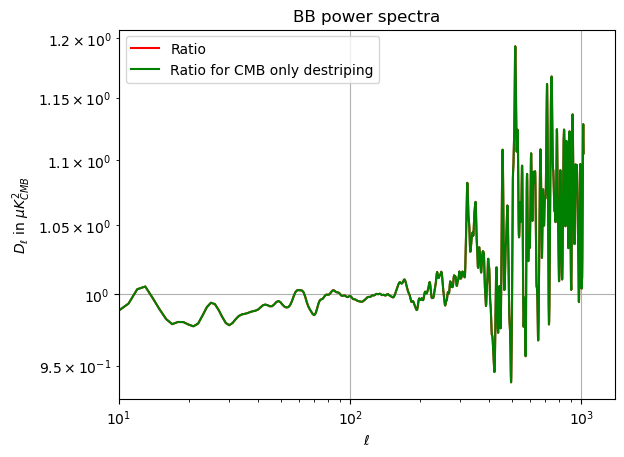

In [41]:
plt.plot(l_arr,Dl_s4_destriping[2]/Dl_in_mask[2], 'r-', label = r'Ratio')
#plt.plot(l_arr,Dl_s4_destriping_cor[2]/Dl_in_mask[2], 'b-', label = r'Ratio with mode addition from Planck')
plt.plot(l_arr,Dl_cmb_des_mask[2]/Dl_in_mask[2], 'g-', label = r'Ratio for CMB only destriping')

#plt.plot(l_arr,Dl_s4_destriping_cor[0]*1e12/sky_fraction, 'r-', label = r'Output corrected map (destriping)')

#plt.plot(l_arr,Dl_s4_dc0[0]*1e12/sky_fraction, 'g-', label = r'Output map (dc0)')
#plt.plot(l_arr,Dl_s4_dc0_cor[0]*1e12/sky_fraction, 'r-', label = r'Output corrected map (dc0)')

#plt.plot(l_arr,Dl_diff_noise[0]*1e12/sky_fraction, 'r.', label = r'Residual map')
plt.xlabel('$\ell$')
plt.ylabel('$D_{\ell}$ in $\mu K_{CMB}^2$')
plt.legend(loc = 'best')
plt.xscale('log')
plt.yscale('log')
plt.title(2*mode_list[2]+' power spectra')
plt.xlim(left = 10)
plt.grid()
##plt.savefig(output_noise+'/cls_comparison'+2*mode_list[0],format = 'svg')
plt.show()

In [42]:
diff0 = mask_cmb_des-masked_cmb_in
diff_mask2  = masked_map(diff0,mask_sm)

In [43]:
diff3 = cmb_dc0 - cmb_input
diff_mask3 = masked_map(diff3,mask_sm)

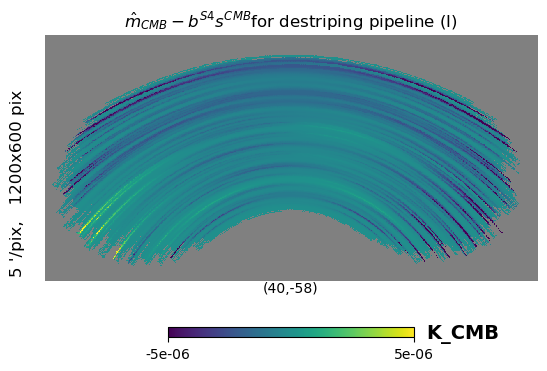

In [49]:
hp.gnomview(diff_mask2[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -5e-6,max = 5e-6, title = r'$\hat{m}_{CMB}-b^{S4}s^{CMB}$' +'for destriping pipeline (I)', unit='K_CMB')

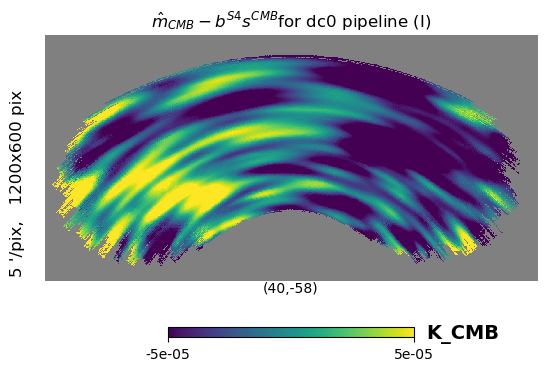

In [51]:
hp.gnomview(diff_mask3[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -5e-5,max = 5e-5, title = r'$\hat{m}_{CMB}-b^{S4}s^{CMB}$' +'for dc0 pipeline (I)', unit='K_CMB')

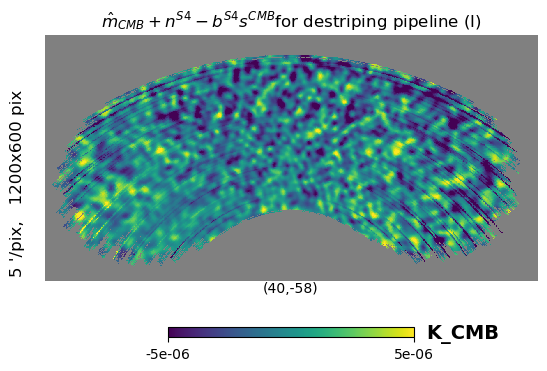

In [53]:
hp.gnomview(diff_mask[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -5e-6,max = 5e-6, title = r'$\hat{m}_{CMB}+n^{S4}-b^{S4}s^{CMB}$' +'for destriping pipeline (I)', unit='K_CMB')